Подключаем библиотеки

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/DataSet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.decomposition import PCA
%matplotlib inline

Mounted at /content/drive
/content/drive/My Drive/DataSet


In [ ]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Дублирование

In [ ]:
data.duplicated().sum()

0

Типы данных

In [ ]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Удаляем категориальные признаки nameOrig и nameDest так как они уникальны для каждой транзакции

In [ ]:
data = data.drop(['nameOrig', 'nameDest'], axis = 1)

Матрица корреляции

In [ ]:
corr = data.corr()
cm = sns.color_palette("magma", as_cmap=True)
corr.style.background_gradient(cmap=cm)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


Категориальный признак type

In [ ]:
data['type'].describe()

count      6362620
unique           5
top       CASH_OUT
freq       2237500
Name: type, dtype: object

Кодируем type

In [ ]:
data = pd.get_dummies(data, columns = ['type'])
data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


Проверка на сбалансированность данных

In [ ]:
data['isFraud'].value_counts()


0    6354407
1       8213
Name: isFraud, dtype: int64

Визуализация

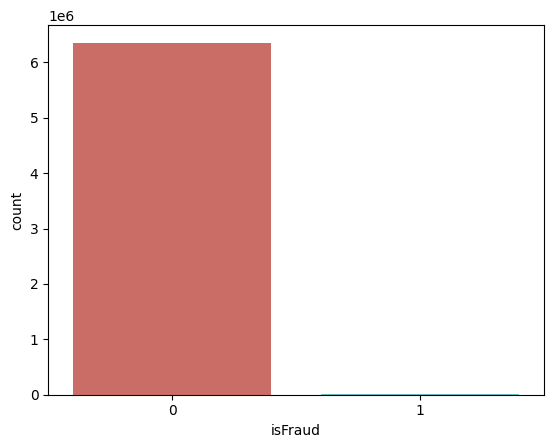

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.countplot(x='isFraud', data = data, palette = 'hls')
plt.show()
plt.savefig('count_plot')

В процентах

In [ ]:
count_fraud = len(data[data['isFraud'] == 1])
count_notFraud = len(data[data['isFraud'] == 0])
print(100*count_fraud/(count_fraud + count_notFraud))
print(100*count_notFraud/(count_fraud + count_notFraud))

0.12908204481801522
99.87091795518198


Балансировка

In [ ]:
rat = len(data.loc[data['isFraud']==0])//len(data.loc[data['isFraud']==1])

df_1 = data.loc[data['isFraud']==1]
df_1 = df_1.loc[df_1.index.repeat(rat)]
train_n = pd.concat([data.loc[data['isFraud']==0], df_1]).sample(frac=1)

Исследуем на информативность признаков

In [ ]:
y = train_n['isFraud']
X = train_n.drop('isFraud', axis = 1)

<Axes: >

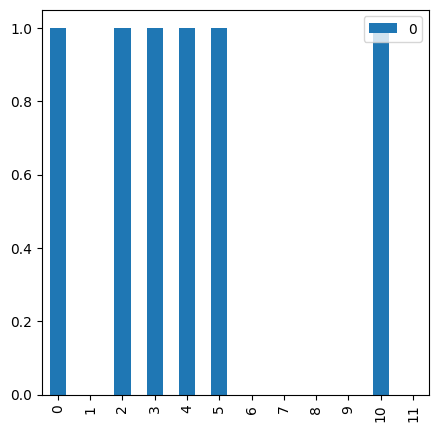

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression()

rfe = RFE(logreg, step=20)
rfe = rfe.fit(X_train, y_train)

features = rfe.get_support()

imp = pd.DataFrame(1*features)
imp.plot.bar(figsize = (5, 5))

Оставляем только информативные признаки

In [ ]:
train_n = train_n.drop(['amount', 'isFlaggedFraud','type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_TRANSFER'], axis = 1)

In [ ]:
train_n.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5563782,391,CASH_OUT,495773.64,495773.64,0.00,269095.07,764868.71,1,0
4297546,307,TRANSFER,376367.26,376367.26,0.00,0.00,0.00,1,0
6362486,732,TRANSFER,59677.48,59677.48,0.00,0.00,0.00,1,0
1711396,160,TRANSFER,360749.76,360749.76,0.00,0.00,0.00,1,0
2555030,206,CASH_IN,91757.74,3434752.15,3526509.88,148182.99,56425.25,0,0


Берём выборку из 20000 строк

In [ ]:
data = train_n.sample(n = 20000, random_state=1)

In [ ]:
y = data['isFraud']
X = data.drop('isFraud', axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
logreg = LogisticRegression(class_weight='balanced', n_jobs = -1)

Кросс-валидация до подбора

In [ ]:
scores = cross_val_score(logreg, X, y, cv=5)

scores

array([0.89025, 0.91   , 0.905  , 0.90225, 0.90775])

Подбор параметров модели

In [ ]:
model = LogisticRegression()
parameters = {'solver': ['newton-cg', 'liblinear', 'sag', 'saga', 'newton-cholesky']}

grid_clf = GridSearchCV(model, parameters, cv=5, scoring='accuracy', n_jobs = -1)
grid_clf.fit(X, y)

print(grid_clf.best_estimator_)
print(grid_clf.best_params_)
print(grid_clf.best_score_)

LogisticRegression(solver='newton-cholesky')
{'solver': 'newton-cholesky'}
0.9474500000000001


Обучение на подобранных параметрах

In [ ]:
bestModel = LogisticRegression(solver = grid_clf.best_params_['solver'])
bestModel.fit(X_train, y_train)

LogisticRegression(solver='newton-cholesky')

Кросс-валидация после подбора

In [ ]:
scores = cross_val_score(bestModel, X, y, cv=5)

scores

array([0.9495 , 0.94   , 0.9525 , 0.9495 , 0.94575])

Метрики на тестовой выборке

In [ ]:
pred = bestModel.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3046
           1       0.95      0.95      0.95      2954

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



In [ ]:
confusion_matrix(y_test, pred)

array([[2886,  160],
       [ 151, 2803]])

Сохраним

In [ ]:
with open("LogisticRegression.pickle", "wb") as file:
    pickle.dump(bestModel, file)

Сжимаем до двух комонент

In [ ]:
pca = PCA(n_components = 2)
pca.fit(X)

X_new = pca.transform(X)

In [ ]:
model = LogisticRegression()
parameters = {'solver': ['newton-cg', 'liblinear', 'sag', 'saga', 'newton-cholesky']}

grid_clf = GridSearchCV(model, parameters, cv=5, scoring='accuracy', n_jobs = -1)
grid_clf.fit(X_new, y)

print(grid_clf.best_estimator_)
print(grid_clf.best_params_)
print(grid_clf.best_score_)

LogisticRegression(solver='newton-cg')
{'solver': 'newton-cg'}
0.6259499999999999


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size = 0.3, random_state = 42)

In [ ]:
bestModel = LogisticRegression(solver = grid_clf.best_params_['solver'])
scores = cross_val_score(bestModel, X_new, y, cv=5)
scores

array([0.66825, 0.60225, 0.58625, 0.61175, 0.66125])

In [ ]:
bestModel.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [ ]:
pred = bestModel.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.51      0.89      0.65      2953
           1       0.61      0.16      0.26      3047

    accuracy                           0.52      6000
   macro avg       0.56      0.53      0.45      6000
weighted avg       0.56      0.52      0.45      6000



Точность сильно упала

In [ ]:
confusion_matrix(y_test, pred)

array([[2633,  320],
       [2553,  494]])